# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

In [ ]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2023-03-13 01:02:14--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat’

notMNIST_small.mat  100%[===================>] 112.14M  49.0MB/s    in 2.3s    

2023-03-13 01:02:17 (49.0 MB/s) - ‘notMNIST_small.mat’ saved [117586976/117586976]



In [ ]:
import matplotlib.pyplot as plt
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split

## Data Loading

In [ ]:
data = io.loadmat("notMNIST_small.mat")

# transform data
X = data['images']
y = data['labels']
resolution = 28
classes = 10

X = np.transpose(X, (2, 0, 1))

y = y.astype('int32')
X = X.astype('float32') / 255. # 이미지 데이터다 보니까 min값이 0이니 max값으로 나눈 min max scaling

# shape: (sample, x, y, channel)
X = X.reshape((-1, resolution, resolution, 1))

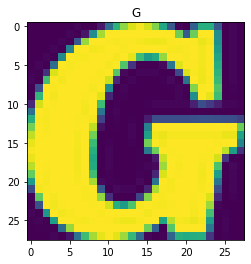

In [ ]:
# looking at data; some fonts are strange
i = np.random.randint(0, 18724)

plt.imshow(X[i,:,:,0])
plt.title("ABCDEFGHIJ"[y[i]]);

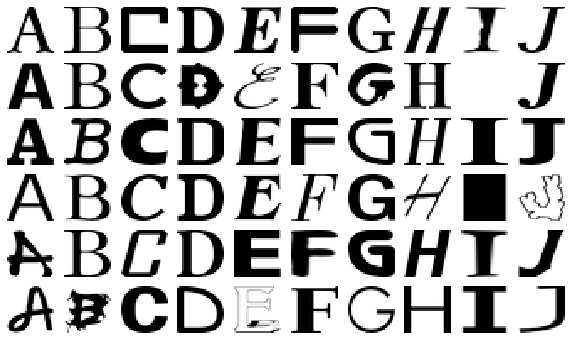

In [ ]:
# random letters
rows = 6
fig, axs = plt.subplots(rows, classes, figsize=(classes, rows))

for letter_id in range(10):
    letters = X[y == letter_id]
    for i in range(rows):
        ax = axs[i, letter_id]
        ax.imshow(letters[np.random.randint(len(letters)),:,:,0],
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [ ]:
# splitting data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2022)

In [ ]:
x_train.shape, y_train.shape

((14979, 28, 28, 1), (14979,))

# Keras를 이용한 모델링 훈련!

1. Flatten layer 활용
2. activation이 주어진 Dense layer뒤에 BatchNormalization둬볼 것 
3. Dropout을 0.2 정도로 활용해볼 것
4. Early stopping도 활용해볼 것

In [ ]:
# import 
import tensorflow as tf
from tensorflow import keras

In [15]:
from tensorflow.keras.utils import to_categorical

In [16]:
# y 전처리 > 각 범주에 맞춰서 나누기 
class_n = len(np.unique(y_train))

In [17]:
y_train = to_categorical(y_train, class_n)
y_test = to_categorical(y_test, class_n)
# 원래 to_categorical은 원래 알아서 다 해주는데 능동적으로 할 수 있도록 class_n을 두번째 인자로 넣어주는 것

In [18]:
y_train.shape

(14979, 10)

In [21]:
## 모델링 : Sequential API
# 1. 세션 클리어 : 기존 모델 구조가 메모리에 남아있다면 지워줘
keras.backend.clear_session()
# 2. 모델 선언(모델 발판 생성) : 레이어 블록을 차곡차곡 쌓을!
model = keras.models.Sequential()
# 3. 모델 블록 조립 : .add() 구조에 맞춰서 shape 맞춰주기
model.add( keras.layers.Input(shape=(28, 28, 1)) )
model.add( keras.layers.Flatten() ) # 쫙 펼쳐주는 Flatten
model.add( keras.layers.Dense(512, activation = 'relu') ) # hiden layers 
model.add( keras.layers.Dense(512, activation = 'relu') ) # hiden layers 
model.add( keras.layers.BatchNormalization() ) # Batch Normaliztion
model.add( keras.layers.Dropout(0.2) ) 
# drop out과 Batch Normaliztion >> 모델 성능을 좋게 하기 위한 테크닉 기법 
# 그래서 레이어 인풋 아웃풋 사이에 들어갈 순 있지만 아웃풋 뒤에 들어가선 ㄴㄴ

model.add( keras.layers.Dense(256, activation = 'relu') ) # hiden layers 
model.add( keras.layers.Dense(256, activation = 'relu') ) # hiden layers 
model.add( keras.layers.BatchNormalization() ) # Batch Normaliztion
model.add( keras.layers.Dropout(0.2) )  
# Dropoup
# 제프리힌튼온이 주장함. 학습 과정에서 20%의 노드를 랜덤하게 죽이는 것
# 모델 구조에 딱 맞춰서 학습이 되다보면 overfitting 현상이 실제로 일어나는데 의도적으로 노드를 랜덤하게 학습 과정에서 죽임으로써 
# 조금 더 general하게 쓰이도록 만드는 것 robust한 모델 강건한 모델을 만드는 것이라고 말하고, 때문에 각각에 같은 구조를 가진다고 했을 때
# 가중치는 매우 다르거든요 그래서 어떤 분은 학습이 매우 잘되고, 어떤 분은 학습이 매우 덜되고 이런 게 잘 없고 초기값에 영향을 잘 받지 않도록 만들어주는게 드롭아웃

# BatchNormaliztion
# 2015년에 나온 논문! 배치노말라이제이션
# 배치란 학습되는 전체 ㅇㅇㅇ을 의미하는데 그걸 쪼개서 뭉텅이들로 학습시킨다 이것을 mini-batch라고 한다
# 정확하게 말하면 미니배치노말라이제이션이다. 미니배치라는 것이 한 에폭스가 돌때마다 랜덤하게 바뀌는데 가중치에 따른 값들 또한 ㅇㅇ
# 분포가 급격하게 바뀐다. covariate shift라 하고 이게 히든레이어에서 발생한다고 internal covariate shift라고 불렀어요 이걸 막아보자고 
# 미니배치 단위로도 스케일링을 해보자 라고 하는게 저자의 의도임.
# hidden레이어를 거치고 > Normaliztion을 거쳐서 > Activation을 해야 한다고 저자는 말했음. 하지만 우리가 한 형태는?
# Activation을 먼저 했지. 이게 굉장한 논쟁거리임 들어온 데이터에 대해서 스케일링하고 액티베이션 넘겨야 하지 않냐.. 근데 실험을 해보니까 논문 저자야
# hidden > act > normal 하니까 성능이 더 좋게 나왔어 해서 이 방식을 사용하고 있음 실제로 

model.add( keras.layers.Dense(10, activation='softmax'))

# 4. 컴파일
model.compile(loss = keras.losses.categorical_crossentropy, metrics = ['accuracy'],
             optimizer = 'adam')
# 양념
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                        

In [26]:
## Fuctional API
# 1. 세션  클리어
keras.backend.clear_session()
# 2. 레이어 사슬처럼 엮기
il = keras.layers.Input(shape=(28,28,1)) # 순차적으로 모든 레이어가 모두 연결되어 있는 Fully Connected 구조
fl = keras.layers.Flatten()(il)

hl = keras.layers.Dense(512, activation = 'relu')(fl)
hl = keras.layers.Dense(512, activation = 'relu')(hl)
bl = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bl) # 변수명은 순차적으로 쌓고 있다는 전제하에 모든 것이 h1으로 동일해도 상관 x

hl = keras.layers.Dense(512, activation = 'relu')(fl)
hl = keras.layers.Dense(512, activation = 'relu')(hl)
bl = keras.layers.BatchNormalization()(hl)
dl = keras.layers.Dropout(0.2)(bl)

ol = keras.layers.Dense(10, activation = 'softmax')(dl)
# 3. 모델의 시작/끝 지정
model = keras.models.Model(il, ol)
# 4. 컴파일
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],
              optimizer = 'adam')
# 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               401920    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                             

In [ ]:
# 조금 빠르게 멈출 수 있는 것, 과적합 방지용 
from tensorflow.keras.callbacks import EarlyStopping

In [22]:
es = EarlyStopping(monitor = 'val_loss', # 관측 대상 : 얼리스토핑을 무엇을 보고 적용할래
                   min_delta = 0,        # 임계값 : Threshold : 관측 대상이 이정도는 개선되어야 개선됐다고 볼래
                   patience = 5,         # 성능 개선되지 않더라도 몇 번 참을래?
                   verbose = 1,          # 얼리 스톱핑이 어디서 적용되는지 알려주는 옵션
                   restore_best_weights = True) # 가장 성능이 좋았던 epochs의 가중치를 쓸거야

In [23]:
# EarlyStopping을 어떻게 쓰느냐?
model.fit(x_train, y_train, 
          validation_split = 0.2, 
          callbacks=[es],
          verbose = 1, epochs = 10000)

Epoch 1/10000
375/375 [==============================] - 10s 21ms/step - loss: 0.5733 - accuracy: 0.8317 - val_loss: 0.7719 - val_accuracy: 0.8134
Epoch 2/10000
375/375 [==============================] - 7s 18ms/step - loss: 0.3786 - accuracy: 0.8859 - val_loss: 0.4337 - val_accuracy: 0.8822
Epoch 3/10000
375/375 [==============================] - 8s 22ms/step - loss: 0.3207 - accuracy: 0.9040 - val_loss: 0.5056 - val_accuracy: 0.8715
Epoch 4/10000
375/375 [==============================] - 9s 24ms/step - loss: 0.2779 - accuracy: 0.9154 - val_loss: 0.4081 - val_accuracy: 0.8835
Epoch 5/10000
375/375 [==============================] - 9s 25ms/step - loss: 0.2689 - accuracy: 0.9191 - val_loss: 0.5037 - val_accuracy: 0.8611
Epoch 6/10000
375/375 [==============================] - 10s 25ms/step - loss: 0.2349 - accuracy: 0.9278 - val_loss: 0.4094 - val_accuracy: 0.8929
Epoch 7/10000
375/375 [==============================] - 11s 29ms/step - loss: 0.2125 - accuracy: 0.9336 - val_loss: 0.480

In [ ]:
pred_train = model.predict(x_train)
pred_test = model.predict(x_test)